This notebook contains the second Coffee-Grading Model, which will now classify beans into 4 categories, imitating the original task of identifying bean defects even closer.

In [59]:
import tensorflow as tf
import os
import cv2
import imghdr
from matplotlib import pyplot as plt
import numpy as np
import math
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

In [60]:
data_dir = 'data'
print(os.listdir(data_dir))

['defect', 'longberry', 'peaberry', 'premium']


In [61]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

Sub-Model1

In [62]:
data = tf.keras.utils.image_dataset_from_directory('data') # Here, we load the data from the directory

Found 8000 files belonging to 4 classes.


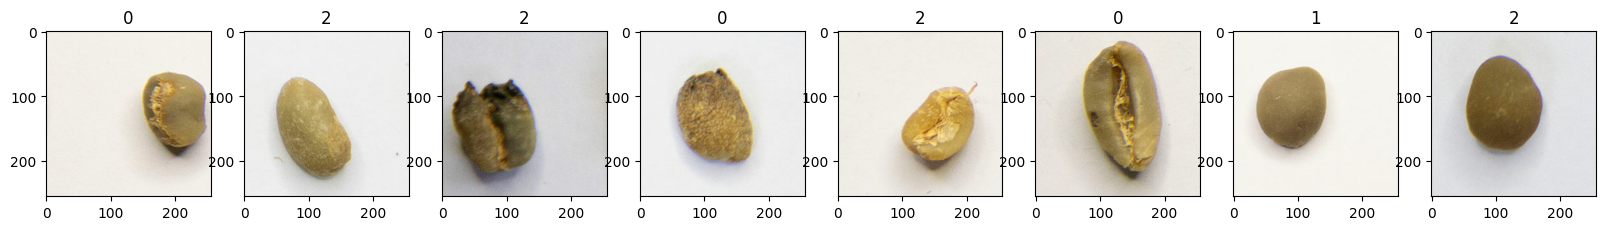

In [63]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=8, figsize=(20,20)) 
for idx, img in enumerate(batch[0][8:16]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [64]:
def normalize(x, y):
    return x / 255, y

data = data.map(normalize)
# This code box normalizes our dataset

In [65]:
total_size = len(data)
train_size = math.floor(total_size * 0.7)
val_size = math.floor(total_size * 0.2)
test_size = total_size - train_size - val_size

In [66]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)
len(train) # Number of bathces

175

The code cell below shows the distribution of classes, which is equal, as expected.


In [67]:
# import matplotlib.pyplot as plt

# # Define a function to separate features and labels
# def separate_features_and_labels(features, label):
#     return features, label

# # Apply the function to each element of the dataset to separate features and labels
# train_features_and_labels = train.map(separate_features_and_labels)


# # Extract features and labels into separate lists
# train_features = []
# train_labels = []

# for features, label in train_features_and_labels:
#     train_features.append(features)
#     train_labels.append(label)

# # Convert lists to NumPy arrays if needed
# train_features = np.array(train_features)
# train_labels = np.array(train_labels)

# # Assuming 'y' contains the class labels
# class_labels, class_counts = np.unique(train_labels, return_counts=True)

# # Plot class distribution
# plt.figure(figsize=(8, 6))
# plt.bar(class_labels, class_counts, color='skyblue')
# plt.xlabel('Class Label')
# plt.ylabel('Frequency')
# plt.title('Class Distribution')
# plt.xticks(class_labels)
# plt.show()

# # Print class frequencies
# for label, count in zip(class_labels, class_counts):
#     print(f'Class {label}: {count} samples') 

# # Class distribution is rather equal.

Model 1. Regular CNN. Similar to the model that works with 2 classes, yet this one has 4.

In [68]:
model = Sequential()
model.add(Conv2D(32, (2, 2), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(64, (2, 2), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (2, 2), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))  # Changing to 4 for four classes and using softmax

In [69]:
# Compile the model with the updated loss function
learning_rate = 0.0005  
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 255, 255, 32)      416       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_25 (Conv2D)          (None, 126, 126, 64)      8256      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_26 (Conv2D)          (None, 62, 62, 32)        8224      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 32)      

In [70]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [71]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
175/175 [==============================] - 22s 115ms/step - loss: 1.2309 - accuracy: 0.4284 - val_loss: 0.9773 - val_accuracy: 0.6012
Epoch 2/20
175/175 [==============================] - 20s 116ms/step - loss: 0.8454 - accuracy: 0.6550 - val_loss: 0.8257 - val_accuracy: 0.6762
Epoch 3/20
175/175 [==============================] - 20s 115ms/step - loss: 0.6970 - accuracy: 0.7262 - val_loss: 0.7119 - val_accuracy: 0.7256
Epoch 4/20
175/175 [==============================] - 20s 116ms/step - loss: 0.5806 - accuracy: 0.7773 - val_loss: 0.7579 - val_accuracy: 0.7063
Epoch 5/20
175/175 [==============================] - 20s 117ms/step - loss: 0.5079 - accuracy: 0.8034 - val_loss: 0.6730 - val_accuracy: 0.7456
Epoch 6/20
175/175 [==============================] - 21s 117ms/step - loss: 0.4091 - accuracy: 0.8500 - val_loss: 0.6142 - val_accuracy: 0.7731
Epoch 7/20
175/175 [==============================] - 20s 116ms/step - loss: 0.3541 - accuracy: 0.8704 - val_loss: 0.6647 - val_ac

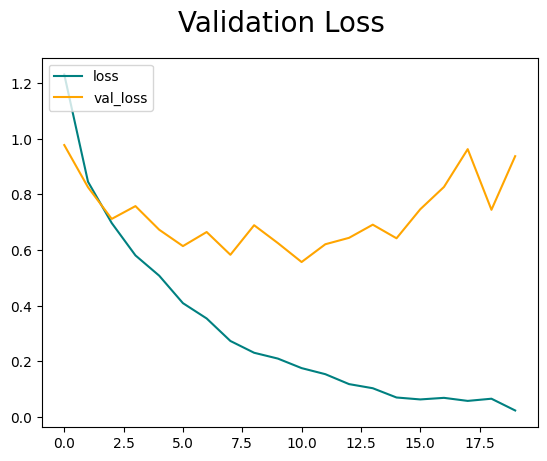

In [72]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Validation Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

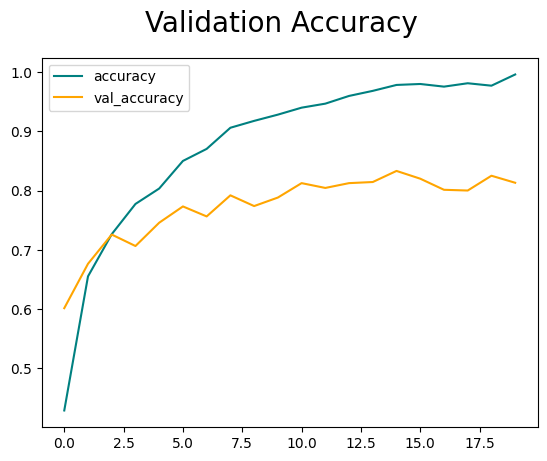

In [73]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Validation Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [74]:
precision = Precision()
recall = Recall()
accuracy = CategoricalAccuracy()
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    yhat = tf.argmax(yhat, axis=1)  # Convert predictions to label indices
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

1/1 [==============================] - 0s 47ms/step


In [75]:
print(precision.result().numpy(), recall.result().numpy(), accuracy.result().numpy())

0.90111643 0.93698174 0.64


In [ ]:
model.save(os.path.join('models','CoffeeModel2.h5'))

Model 2.  Residual Neural Network. Residual neural network will allow us to create a tryly deep neural network with many layers, which will still be susceptible to training, because it is, well, residual.

In [15]:
def residual_block(x, filters, kernel_size=3, stride=1):
    x_og = x
    
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x) 
    # Batch normalization helps prevent Internal Covariate Shift by normalizing the data.
    # After normalization, the normalized activations are scaled and shifted using learnable parameters γ and 𝛽
    # Also, Batch Normalization reduces this dependency, making the training process less sensitive 
    # to the initial starting conditions.
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    
    if stride != 1 or x.shape[-1] != x_og.shape[-1]: # In case the shape of the output of the block is different from the input one
        x_og = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', kernel_initializer='he_normal')(x_og)
        x_og = layers.BatchNormalization()(x_og)
    
    x = layers.add([x, x_og]) # Here we add the input to the output of a block. 
    x = layers.ReLU()(x)
    
    return x

In [16]:
def build_resnet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same', kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    x = residual_block(x, 32)
    x = residual_block(x, 32)
    
    x = residual_block(x, 48, stride=2)
    x = residual_block(x, 48)
    
    x = residual_block(x, 96, stride=2)
    x = residual_block(x, 96)
    
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)
    
    x = layers.GlobalAveragePooling2D()(x) 
    # Global average pooling is a technique to reduce each channel in the feature map to a single value by 
    # taking the average of all values in that channel.
    x = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, x)
    
    return model


In [17]:
input_shape = (256, 256, 3)  
num_classes = 4

model = build_resnet(input_shape, num_classes)
model.compile(optimizer=Adam(learning_rate=0.0003), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 128, 128, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d_3[0][0]']               
 alization)                     )                                                             

In [27]:
logdir='logs2'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
checkpoint_filepath = "weights/best_weights4.h5"
# Seting up the ModelCheckpoint callback to save the model's best weight values.
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, 
                                      monitor='val_accuracy', 
                                      save_best_only=True,  # Save weights at each epoch, not just the best
                                      save_weights_only=True,  # Only save the model weights
                                      mode='max')

In [21]:
def one_hot_encode(data, label):
    num_classes = 4  # Set this to the number of classes in your dataset
    label = tf.one_hot(label, num_classes)  # Subtract 1 to make labels zero-based for one-hot encoding
    return data, label


In [22]:
one_hot_train = train.map(one_hot_encode)
one_hot_valid = val.map(one_hot_encode)
one_hot_test = test.map(one_hot_encode)

In [23]:
# for data, label in one_hot_test.take(1):
#     print("Data shape:", data.shape)
#     print("Label shape:", label.shape)
#     print("Label:", label.numpy())

In [24]:
hist2 = model.fit(one_hot_train, epochs=16, validation_data=one_hot_valid, callbacks=[tensorboard_callback, checkpoint_callback], batch_size=48)

# Best Accuracy = 0.98, Val_Ac=0.84

Epoch 1/16
175/175 [==============================] - 44s 146ms/step - loss: 0.6624 - accuracy: 0.7421 - val_loss: 4.0890 - val_accuracy: 0.2912
Epoch 2/16
175/175 [==============================] - 26s 146ms/step - loss: 0.3996 - accuracy: 0.8518 - val_loss: 0.8692 - val_accuracy: 0.7144
Epoch 3/16
175/175 [==============================] - 25s 144ms/step - loss: 0.3006 - accuracy: 0.8952 - val_loss: 4.4976 - val_accuracy: 0.4075
Epoch 4/16
175/175 [==============================] - 26s 146ms/step - loss: 0.2573 - accuracy: 0.9045 - val_loss: 1.0119 - val_accuracy: 0.7175
Epoch 5/16
175/175 [==============================] - 26s 146ms/step - loss: 0.2152 - accuracy: 0.9236 - val_loss: 1.0973 - val_accuracy: 0.6650
Epoch 6/16
175/175 [==============================] - 26s 146ms/step - loss: 0.1800 - accuracy: 0.9311 - val_loss: 2.9392 - val_accuracy: 0.4588
Epoch 7/16
175/175 [==============================] - 26s 148ms/step - loss: 0.1437 - accuracy: 0.9463 - val_loss: 0.4758 - val_ac

In [ ]:
fig = plt.figure()
plt.plot(hist2.history['loss'], color='teal', label='loss')
plt.plot(hist2.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Validation Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist2.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist2.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Validation Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [52]:
precision = Precision()
recall = Recall()
accuracy = CategoricalAccuracy()
def f1_score(precision, recall):
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

# False Positive Rate (FPR) metric
def false_positive_rate(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Casting to float32 for consistency
    y_pred = tf.cast(tf.round(y_pred), tf.float32)  # Casting predictions to float32
    false_positives = tf.math.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))  # Sum of false positives
    possible_negatives = tf.math.reduce_sum(tf.cast(1 - y_true, tf.float32))  # Sum of possible negatives
    return false_positives / (possible_negatives + tf.keras.backend.epsilon())  # Calculating FPR

count = 0
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    yhat = tf.argmax(yhat, axis=1)  # Convert predictions to label indices
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    if count < 5:
        print(yhat[:8])
        print(y[:8])
        count += 1
    accuracy.update_state(y, yhat)

1/1 [==============================] - 0s 54ms/step
tf.Tensor([1 2 0 2 2 3 0 2], shape=(8,), dtype=int64)
[1 2 0 2 2 3 2 2]
1/1 [==============================] - 0s 35ms/step
tf.Tensor([0 1 3 1 2 2 0 0], shape=(8,), dtype=int64)
[0 1 3 1 2 2 0 0]
1/1 [==============================] - 0s 36ms/step
tf.Tensor([2 2 0 0 3 2 1 3], shape=(8,), dtype=int64)
[2 2 0 0 3 2 1 3]
1/1 [==============================] - 0s 33ms/step
tf.Tensor([2 0 1 1 1 3 1 0], shape=(8,), dtype=int64)
[2 0 1 1 1 3 1 0]
1/1 [==============================] - 0s 29ms/step
tf.Tensor([0 1 0 2 0 3 0 1], shape=(8,), dtype=int64)
[0 1 0 2 0 3 0 1]
1/1 [==============================] - 0s 31ms/step


In [54]:
# Calculate the final metric values
precision_value = precision.result().numpy()
recall_value = recall.result().numpy()
accuracy_value = accuracy.result().numpy()
f1_value = f1_score(precision_value, recall_value)
fpr_value = false_positive_rate(y, yhat).numpy()

# Print the final metric results
print(f"Precision: {precision_value:.4f}")
print(f"Recall: {recall_value:.4f}")
print(f"Accuracy: {accuracy_value:.4f}")
print(f"F1 Score: {f1_value:.4f}") 
print(f"False Positive Rate: {fpr_value:.4f}")

Precision: 0.9964
Recall: 0.9423
Accuracy: 0.8800
F1 Score: 0.9686
False Positive Rate: 3.4286


In [33]:
model.save(os.path.join('models','CoffeeModel3v4.h5'))

At first, the model did well to decrease the loss and improve the accuracy, yet did terrible in terms of decreasing validation loss and increasing validation accuracy

In [ ]:
from IPython.display import Image
Image(filename='pictures/val_accv1.png', width=400)

Then, upon increasing the batch size, thus making model updates less noisy, and decreasing learning rate, the train loss greatly reduced and train accuracy greatly increased, and so did validation compatriots, yet validation metrics remained somewhat jumping. During training it became appraent that 30 epochs is too much, as the model starts tio overfit afterwards. 

In [ ]:
Image(filename='pictures/val_accv2.png', width=400)

As you can see, our improvements didn't turn the world upside down, nor did they heal our model. In the next time, O figured that a simpler model would do a better job at generalizing to unseen data, so I made the model twice as simple as it was. My guess was correct, and even though trainign accuracy didn't drop much, the validation metrics, especially validation loss, became way more grounded, yet still a little jumpy. 


In [ ]:
Image(filename='pictures/val_accv3.png', width=400)

After the third model, I spent a considerable amount of time simplifying the model and tuning the hyperparameters, yet I could not get rid of varying validation metrics, which tells us that the main issue of the dataset is its size. Yet, one of the models, during the training, managed to achieve a 90% Validation accuracy, which is a great result given the circumstances. So, below I load the weights from that epoch into my model. 

In [30]:
model.load_weights("weights/top_best_weights2.h5")

In [51]:
val_loss, val_accuracy = model.evaluate(one_hot_valid)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


50/50 [==============================] - 4s 40ms/step - loss: 0.1567 - accuracy: 0.9556
Validation Loss: 0.1567181944847107
Validation Accuracy: 0.9556249976158142


As shown above, that model with the best weights does an excellent job classifying the beans from the dataset. Precision is almost 100%, meaning almost all positive predictions are correct. Accuracy is 88%, showing a great overall guess rate as well. 